### PyTorch TensorBoard Support

Before we Start, to run this tutorial, as also used above, we’ll need to have PyTorch, TorchVision, Matplotlib, and TensorBoard.

With conda:
conda install pytorch torchvision -c pytorch
conda install matplotlib tensorboard

With pip:
pip install torch torchvision matplotlib tensorboard

### Introduction

In this notebook, we’ll be training a variant of LeNet-5 against the Fashion-MNIST dataset. Fashion-MNIST is a set of image tiles depicting various garments, with ten class labels indicating the type of garment depicted.

In [1]:
# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

# In case you are using an environment that has TensorFlow installed,
# such as Google Colab, uncomment the following code to avoid
# a bug with saving embeddings to your TensorBoard directory

# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

### Showing Images in TensorBoard

Let's start by adding sample images from our dataset to TensorBoard:

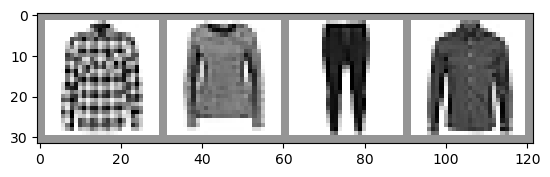

In [2]:
# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Store separate training and validations splits in ./data
training_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
validation_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

training_loader = torch.utils.data.DataLoader(training_set,
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=2)


validation_loader = torch.utils.data.DataLoader(validation_set,
                                                batch_size=4,
                                                shuffle=False,
                                                num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

Above, we used TorchVision and Matplotlib to create a visual grid of a minibatch of our input data. Below, we use the add_image() call on SummaryWriter to log the image for consumption by TensorBoard, and we also call flush() to make sure it’s written to disk right away.

In [4]:
# Default log_dir argument is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# Write image data to TensorBoard log dir
writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

If you start TensorBoard at the command line and open it in a new browser tab (usually at localhost:6006), you should see the image grid under the IMAGES tab.

### Graphing scalars to Visualize Training

TensorBoard is useful for tracking the progress and efficacy of your training. Below, we’ll run a training loop, track some metrics, and save the data for TensorBoard’s consumption.

Let’s define a model to categorize our image tiles, and an optimizer and loss function for training:

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Now let's train a single epoch, and evaluate the training vs. validation set losses every 1000 batches:

In [6]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='logs')  # You can specify your own log directory

print(len(validation_loader))
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        # basic training loop
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # Every 1000 mini-batches...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0

            # In evaluation mode some model specific operations can be omitted eg. dropout layer
            net.train(False) # Switching to evaluation mode, eg. turning off regularisation
            for j, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True) # Switching back to training mode, eg. turning on regularisation

            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)

            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(training_loader) + i)

            running_loss = 0.0
print('Finished Training')

writer.flush()

2500
Batch 1000
Batch 2000
Batch 3000
Batch 4000
Batch 5000
Batch 6000
Batch 7000
Batch 8000
Batch 9000
Batch 10000
Batch 11000
Batch 12000
Batch 13000
Batch 14000
Batch 15000
Finished Training


- open TensorBoard and have a look at the SCALARS tab.

### Visualize Your Model

TensorBoard can also be used to examine the data flow within our model. To do this, call the add_graph() method with a model and sample input:

In [7]:
# Again, grab a single mini-batch of images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# add_graph() will trace the sample input through your model,
# and render it as a graph.
writer.add_graph(net, images)
writer.flush()

When we switch over to TensorBoard, we see a GRAPHS tab. Double-click the “NET” node to see the layers and data flow within your model.

### Visualize our Dataset With Embeddings

The 28-by-28 image tiles we’re using can be modeled as 784-dimensional vectors (28 * 28 = 784). It can be instructive to project this to a lower-dimensional representation. The add_embedding() method will project a set of data onto the three dimensions with highest variance, and display them as an interactive 3D chart. The add_embedding() method does this automatically by projecting to the three dimensions with highest variance.

Below, we’ll take a sample of our data, and generate such an embedding:

In [9]:
# Select a random subset of data and corresponding labels
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# Extract a random subset of data
images, labels = select_n_random(training_set.data, training_set.targets)

# get the class labels for each image
class_labels = [classes[label] for label in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.flush()
writer.close()

Now if we switch to TensorBoard and select the PROJECTOR tab, you should see a 3D representation of the projection. You can rotate and zoom the model. Examine it at large and small scales, and see whether you can spot patterns in the projected data and the clustering of labels.

For better visibility, it’s recommended to:

Select “label” from the “Color by” drop-down on the left.

Toggle the Night Mode icon along the top to place the light-colored images on a dark background.

### Training with Pytorch

we’ve discussed and demonstrated:

- Building models with the neural network layers and functions of the torch.nn module

- The mechanics of automated gradient computation, which is central to gradient-based model training

- Using TensorBoard to visualize training progress and other activities

Here, we’ll be adding some new tools to our inventory:

- We’ll get familiar with the dataset and dataloader abstractions, and how they ease the process of feeding data to your model during a training loop

- We’ll discuss specific loss functions and when to use them

- We’ll look at PyTorch optimizers, which implement algorithms to adjust model weights based on the outcome of a loss function

Finally, we’ll pull all of these together and see a full PyTorch training loop in action.

### Dataset and DataLoader

- The Dataset and DataLoader classes encapsulate the process of pulling your data from storage and exposing it to your training loop in batches.

- The Dataset is responsible for accessing and processing single instances of data.

- The DataLoader pulls instances of data from the Dataset (either automatically or with a sampler that you define), collects them in batches, and returns them for consumption by your training loop. The DataLoader works with all kinds of datasets, regardless of the type of data they contain.

- For this tutorial, we’ll be using the Fashion-MNIST dataset provided by TorchVision. We use torchvision.transforms.Normalize() to zero-center and normalize the distribution of the image tile content, and download both training and validation data splits.

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


as always, let's visualize the data as a sanity check:

Ankle Boot  Bag  Sandal  Trouser


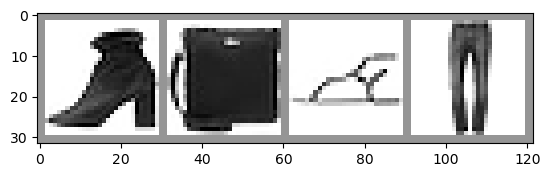

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

### The Model
The model we'll use in this example is a variant of LeNet-5 

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

### Loss Function

For this example, we’ll be using a cross-entropy loss. For demonstration purposes, we’ll create batches of dummy output and label values, run them through the loss function, and examine the result.

In [13]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.8171, 0.7834, 0.4914, 0.7311, 0.4114, 0.3976, 0.9864, 0.0319, 0.8570,
         0.0582],
        [0.5453, 0.1235, 0.9905, 0.1688, 0.6158, 0.3820, 0.0821, 0.1634, 0.1045,
         0.3339],
        [0.2910, 0.0784, 0.0267, 0.3166, 0.7874, 0.0273, 0.3751, 0.5323, 0.9833,
         0.2177],
        [0.2948, 0.1308, 0.6331, 0.6244, 0.3469, 0.5919, 0.9837, 0.1212, 0.4773,
         0.1199]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.371886730194092


### Optimizer

For this example, we’ll be using simple stochastic gradient descent with momentum.

- It can be instructive to try some variations on this optimization scheme:

- Learning rate determines the size of the steps the optimizer takes. What does a different learning rate do to the your training results, in terms of accuracy and convergence time?

- Momentum nudges the optimizer in the direction of strongest gradient over multiple steps. What does changing this value do to your results?

- Try some different optimization algorithms, such as averaged SGD, Adagrad, or Adam. How do your results differ?

In [14]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### The Training Loop

Below, we have a function that performs one training epoch. It enumerates data from the DataLoader, and on each pass of the loop does the following:

- Gets a batch of training data from the DataLoader

- Zeros the optimizer’s gradients

- Performs an inference - that is, gets predictions from the model for an input batch

- Calculates the loss for that set of predictions vs. the labels on the dataset

- Calculates the backward gradients over the learning weights

- Tells the optimizer to perform one learning step - that is, adjust the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose

- It reports on the loss for every 1000 batches.

Finally, it reports the average per-batch loss for the last 1000 batches, for comparison with a validation run

In [15]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

### Per-Epoch Activity

There are a couple of things we’ll want to do once per epoch:

- Perform validation by checking our relative loss on a set of data that was not used for training, and report this

- Save a copy of the model

- Here, we’ll do our reporting in TensorBoard. This will require going to the command line to start TensorBoard, and opening it in another browser tab.

In [16]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.6901529101580381
  batch 2000 loss: 0.8249427909143269
  batch 3000 loss: 0.6664151469357311
  batch 4000 loss: 0.6486672628344968
  batch 5000 loss: 0.6045844884312246
  batch 6000 loss: 0.5728994455763604
  batch 7000 loss: 0.5148874015295878
  batch 8000 loss: 0.4868056160678971
  batch 9000 loss: 0.4944855195689015
  batch 10000 loss: 0.4498815421455947
  batch 11000 loss: 0.4769276915241499
  batch 12000 loss: 0.44204946429200936
  batch 13000 loss: 0.45218149133221597
  batch 14000 loss: 0.4283738553095609
  batch 15000 loss: 0.41037840479710574
LOSS train 0.41037840479710574 valid 0.4195198714733124
EPOCH 2:
  batch 1000 loss: 0.3977363626837032
  batch 2000 loss: 0.39308433271360993
  batch 3000 loss: 0.3999258904707094
  batch 4000 loss: 0.34660072238715656
  batch 5000 loss: 0.39732855732877215
  batch 6000 loss: 0.3738879390925868
  batch 7000 loss: 0.36351543739184855
  batch 8000 loss: 0.3620906348562712
  batch 9000 loss: 0.36566843733523274


To load a saved version of the model

In [ ]:
saved_model = GarmentClassifier()
saved_model.load_state_dict(torch.load("model_20240922_083248_0"))

Once you’ve loaded the model, it’s ready for whatever you need it for - more training, inference, or analysis.

Note that if your model has constructor parameters that affect model structure, you’ll need to provide them and configure the model identically to the state in which it was saved.



### Model Understanding with Captum

### A First Example

To start, let’s take a simple, visual example. We’ll start with a ResNet model pretrained on the ImageNet dataset. We’ll get a test input, and use different Feature Attribution algorithms to examine how the input images affect the output, and see a helpful visualization of this input attribution map for some test images.

In [1]:
#First, some imports:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

Now we’ll use the TorchVision model library to download a pretrained ResNet. Since we’re not training, we’ll place it in evaluation mode for now.

In [2]:
model = models.resnet18(weights='IMAGENET1K_V1')
model = model.eval()

The place where you got this interactive notebook should also have an img folder with a file cat.jpg in it.

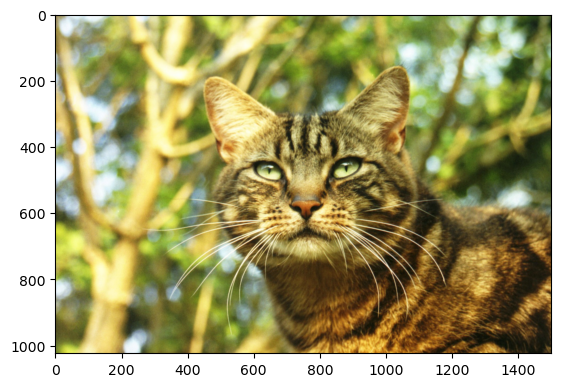

/Users/anjalisuman/Documents/GitHub/ML101


In [3]:
test_img = Image.open('img/cat.jpg')

test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()
import os
print(os.getcwd())


Our ResNet model was trained on the ImageNet dataset, and expects images to be of a certain size, with the channel data normalized to a specific range of values. We’ll also pull in the list of human-readable labels for the categories our model recognizes - that should be in the img folder as well.

In [4]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

labels_path = 'img/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

Now, we can ask the question: What does our model think this image represents?

In [5]:
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: tabby ( 0.56722092628479 )


- We’ve confirmed that ResNet thinks our image of a cat is, in fact, a cat. But why does the model think this is an image of a cat?

- For the answer to that, we turn to Captum.

### Feature Attribution woth Integrated Gradients

- Feature attribution attributes a particular output to features of the input. It uses a specific input - here, our test image - to generate a map of the relative importance of each input feature to a particular output feature.

- Integrated Gradients is one of the feature attribution algorithms available in Captum. Integrated Gradients assigns an importance score to each input feature by approximating the integral of the gradients of the model’s output with respect to the inputs.

- In our case, we’re going to be taking a specific element of the output vector - that is, the one indicating the model’s confidence in its chosen category - and use Integrated Gradients to understand what parts of the input image contributed to this output.

- Once we have the importance map from Integrated Gradients, we’ll use the visualization tools in Captum to give a helpful representation of the importance map. Captum’s visualize_image_attr() function provides a variety of options for customizing display of your attribution data. Here, we pass in a custom Matplotlib color map.

- Running the cell with the integrated_gradients.attribute() call will usually take a minute or two.



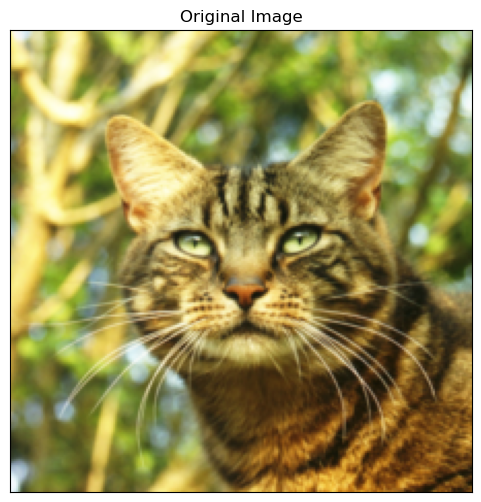

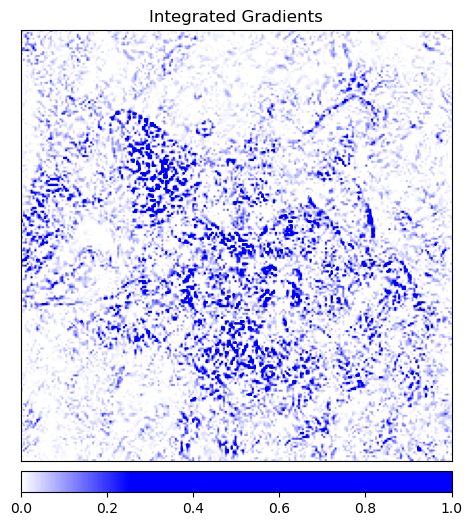

In [6]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(input_img, target=pred_label_idx, n_steps=200)

# Show the original image for comparison
_ = viz.visualize_image_attr(None, np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

### Feature Attribution with Occlusion

- Gradient-based attribution methods help to understand the model in terms of directly computing out the output changes with respect to the input. Perturbation-based attribution methods approach this more directly, by introducing changes to the input to measure the effect on the output. Occlusion is one such method. It involves replacing sections of the input image, and examining the effect on the output signal.

- Below, we set up Occlusion attribution. Similarly to configuring a convolutional neural network, you can specify the size of the target region, and a stride length to determine the spacing of individual measurements. We’ll visualize the output of our Occlusion attribution with visualize_image_attr_multiple(), showing heat maps of both positive and negative attribution by region, and by masking the original image with the positive attribution regions. The masking gives a very instructive view of what regions of our cat photo the model found to be most “cat-like”.

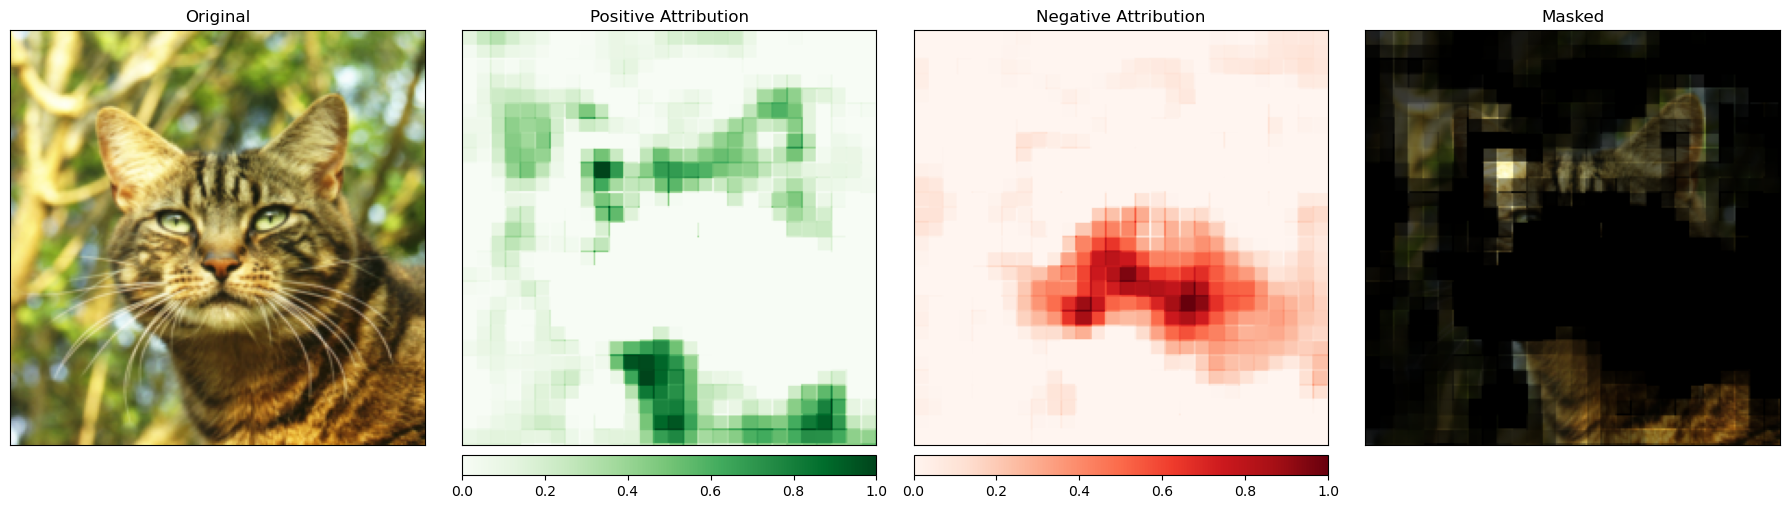

In [7]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input_img,
                                       target=pred_label_idx,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )

Again, we see greater significance placed on the image that contains the cat.

### Layer attribution with Layer GradCAM

- Layer Attribution allows you to attribute the activity of hidden layers within your model to features of your input. Below, we’ll use a layer attribution algorithm to examine the activity of one of the convolutional layers within our model.

- GradCAM computes the gradients of the target output with respect to the given layer, averages for each output channel (dimension 2 of output), and multiplies the average gradient for each channel by the layer activations. The results are summed over all channels. GradCAM is designed for convnets; since the activity of convolutional layers often maps spatially to the input, GradCAM attributions are often upsampled and used to mask the input.

- Layer attribution is set up similarly to input attribution, except that in addition to the model, you must specify a hidden layer within the model that you wish to examine. As above, when we call attribute(), we specify the target class of interest.

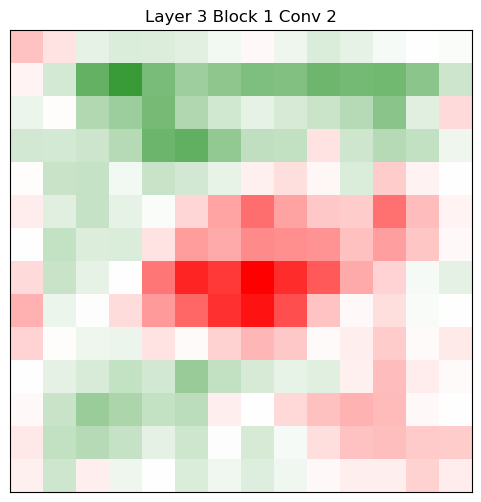

In [8]:
layer_gradcam = LayerGradCam(model, model.layer3[1].conv2)
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)

_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign="all",
                             title="Layer 3 Block 1 Conv 2")

We’ll use the convenience method interpolate() in the LayerAttribution base class to upsample this attribution data for comparison to the input image.

torch.Size([1, 1, 14, 14])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


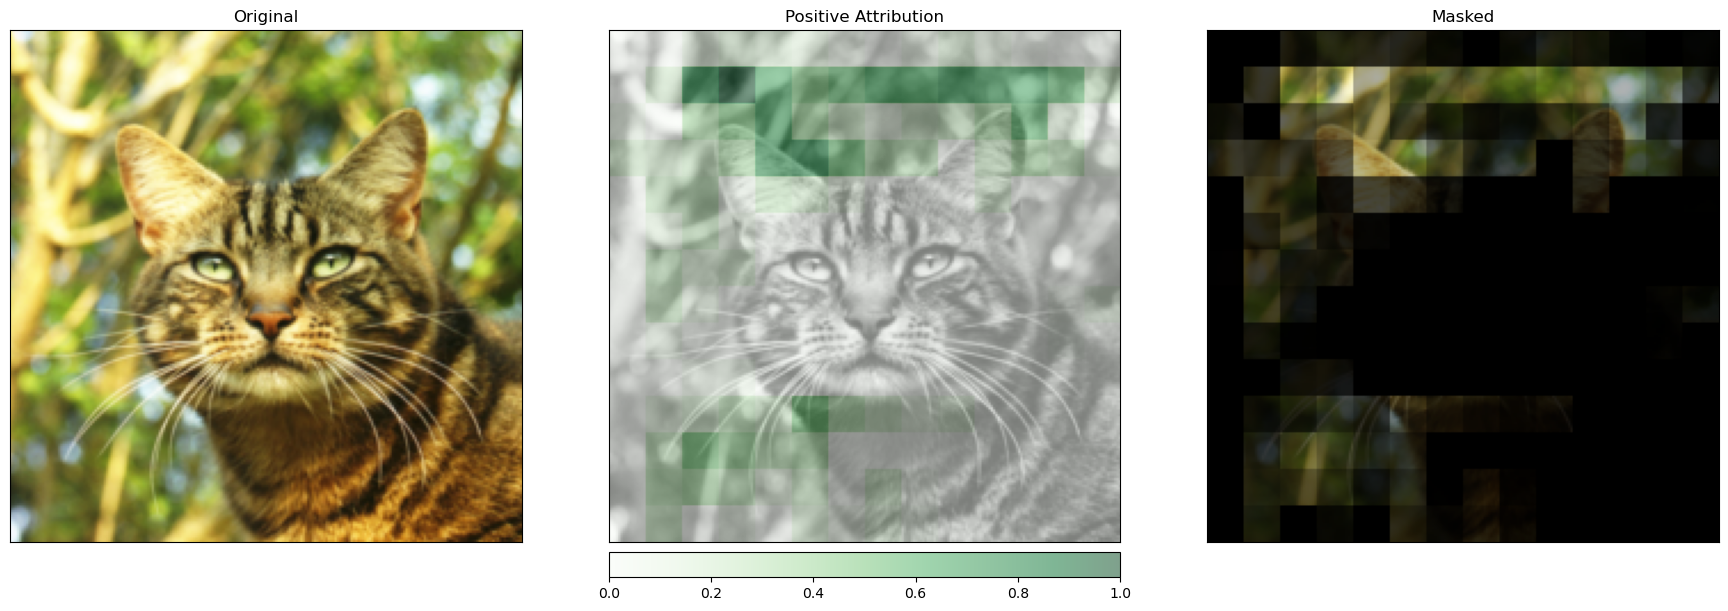

In [9]:
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(input_img.shape)

_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))

Visualizations such as this can give you novel insights into how your hidden layers respond to your input.

### Visualization with Captum Insights

- Captum Insights is an interpretability visualization widget built on top of Captum to facilitate model understanding. Captum Insights works across images, text, and other features to help users understand feature attribution. It allows you to visualize attribution for multiple input/output pairs, and provides visualization tools for image, text, and arbitrary data.

- In this section of the notebook, we’ll visualize multiple image classification inferences with Captum Insights.

- First, let’s gather some image and see what the model thinks of them. For variety, we’ll take our cat, a teapot, and a trilobite fossil:

In [11]:
imgs = ['img/cat.jpg', 'img/teapot.jpg', 'img/trilobite.jpg']

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

Predicted: tabby / 281  ( 0.56722092628479 )
Predicted: teapot / 849  ( 0.9914318323135376 )
Predicted: trilobite / 69  ( 0.999906063079834 )


…and it looks like our model is identifying them all correctly - but of course, we want to dig deeper. For that we’ll use the Captum Insights widget, which we configure with an AttributionVisualizer object, imported below. The AttributionVisualizer expects batches of data, so we’ll bring in Captum’s Batch helper class. And we’ll be looking at images specifically, so well also import ImageFeature.

We configure the AttributionVisualizer with the following arguments:

- An array of models to be examined (in our case, just the one)

- A scoring function, which allows Captum Insights to pull out the top-k predictions from a model

- An ordered, human-readable list of classes our model is trained on

- A list of features to look for - in our case, an ImageFeature

- A dataset, which is an iterable object returning batches of inputs and labels - just like you’d use for training

In [13]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# Baseline is all-zeros input - this may differ depending on your data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    return i


input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=list(map(lambda k: idx_to_labels[k][1], idx_to_labels.keys())),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=[Batch(input_imgs, labels=[282,849,69])]
)

- Note that running the cell above didn’t take much time at all, unlike our attributions above. That’s because Captum Insights lets you configure different attribution algorithms in a visual widget, after which it will compute and display the attributions. That process will take a few minutes.

- Running the cell below will render the Captum Insights widget. You can then choose attributions methods and their arguments, filter model responses based on predicted class or prediction correctness, see the model’s predictions with associated probabilities, and view heatmaps of the attribution compared with the original image.

In [14]:
visualizer.render()

CaptumInsights(insights_config={'classes': ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhe…

Output()